# BBC Articles Clustering



<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-cleaning" data-toc-modified-id="Data-cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data cleaning</a></span></li><li><span><a href="#Vectorization" data-toc-modified-id="Vectorization-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Vectorization</a></span></li><li><span><a href="#True-categories-analysis" data-toc-modified-id="True-categories-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>True categories analysis</a></span></li><li><span><a href="#K-means-clustering-method" data-toc-modified-id="K-means-clustering-method-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>K-means clustering method</a></span></li><li><span><a href="#Agglomerative-clustering" data-toc-modified-id="Agglomerative-clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Agglomerative clustering</a></span></li><li><span><a href="#Results-analysis" data-toc-modified-id="Results-analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Results analysis</a></span></li><li><span><a href="#K-NN-classifier" data-toc-modified-id="K-NN-classifier-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>K-NN classifier</a></span></li></ul></div>

In [1]:
# Libraries for the notebook

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import re
import os

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.cluster import hierarchy

import time


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucialarraona/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data
<a class="anchor" id="Data"></a>

The data set used is the public BBC News data set consisting of 2225 articles, each labeled as one of the five categories: business, entertainment, politics, sport or tech. 

_Original dataset source: http://mlg.ucd.ie/datasets/bbc.html_
_Download file: https://raw.githubusercontent.com/donglinchen/text_classification/master/bbc-text.csv_

Dataset BBC with 2225 articles, divided to 5 categories


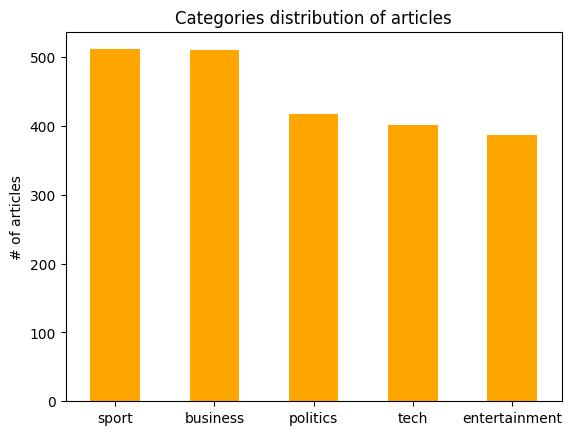

In [2]:
#Upload dataset

#df = pd.read_csv("/work/category.csv")

df= pd.read_csv('https://raw.githubusercontent.com/donglinchen/text_classification/master/bbc-text.csv')

print(
    f"Dataset BBC with {len(df)} articles, divided to {len(df['category'].unique())} categories"
    )

#Plot categories distribution
df['category'].value_counts().plot.bar(rot=0, color='orange')

plt.title('Categories distribution of articles')
plt.ylabel('# of articles')
None

# Text preprocessing
## Data cleaning

In [3]:
#Function for data cleaning


def preprocess_text(text, remove_stopwords):
    """This utility function sanitizes a string by:
        - removing links
        - removing special characters
        - removing numbers
        - removing stopwords
        - transforming in lowercase
        - removing excessive whitespaces
        Args:
            text (str): the input text you want to clean
            remove_stopwords (bool): whether or not to remove stopwords
        Returns:
            str: the cleaned text
        """
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = word_tokenize(text)
        # 2. check if stopword
        tokens = [
            w for w in tokens if not w.lower() in stopwords.words("english")
        ]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [4]:

t1 = time.time()
print('Starting cleaning of data')
tqdm.pandas(dynamic_ncols=True, smoothing=0.01)
#Use function preprocess_text() for every row, assign results to new column 
df['cleaned'] = df['text'].progress_apply(lambda x: preprocess_text(x, remove_stopwords=True))
print('Finished cleaning of data')
t2 = time.time()
print(f'Elapsed time for initilization: {t2-t1:.2f}s')


Starting cleaning of data


  0%|          | 0/2225 [00:00<?, ?it/s]

100%|██████████| 2225/2225 [02:05<00:00, 17.67it/s]

Finished cleaning of data
Elapsed time for initilization: 125.94s


## Vectorization

Vectorize the text cleaned in a previous step. 

In [5]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)

# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(df['cleaned'])

# Clustering


In [6]:
def get_top_keywords(X, clusters, vectorizer, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    dff = pd.DataFrame(X.todense()).groupby(
        clusters).mean()  # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out()  # access tf-idf terms
    for i, r in dff.iterrows():
        print('\nCluster {}'.format(i))
         # for each row of the dataframe, find the n terms that have the highest tf idf score
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) 

Reduce the data dimensionality for visualization. At first we use PCA on a full dataset and use only first 50 principal components. Afterwards we reduce dimensionality to two dimensions with T-SNE algorithm. 

Classification is performed on a full dimensionality.

In [7]:
pca = PCA(n_components=50, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())

X_embedded = TSNE(n_components=2, learning_rate="auto",
                  init="random").fit_transform(pca_vecs)

## True categories analysis

Plot of the datapoints, with reduced dimensionality by using T-SNE. Colours corespond to true categories.

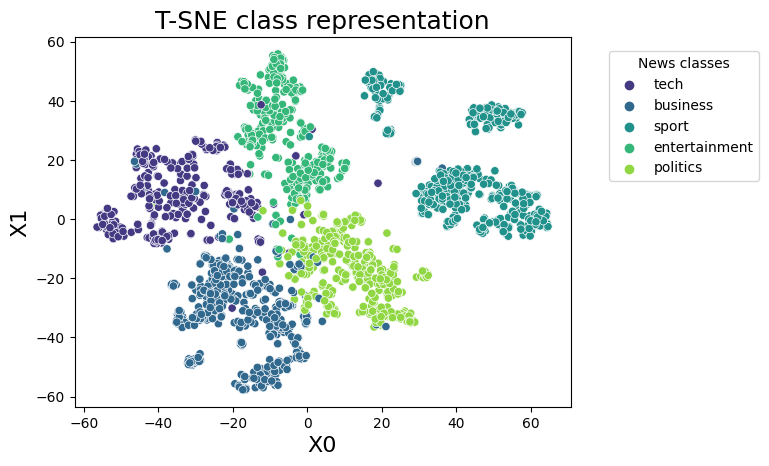

In [8]:
plt.title("T-SNE class representation", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='category',
                palette="viridis")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='News classes')
plt.show()

In [9]:
print('The most central words for each category')
get_top_keywords(X, df['category'], vectorizer, 10)

The most central words for each category

Cluster business
shares,firm,economy,year,company,market,growth,us,said,bn

Cluster entertainment
actor,year,star,said,award,music,awards,show,best,film

Cluster politics
people,minister,would,blair,party,government,said,election,labour,mr

Cluster sport
play,players,first,england,team,match,cup,said,win,game

Cluster tech
net,mobile,digital,use,computer,software,said,technology,users,people


## K-means clustering method

In [10]:
class KMeans:

    def __init__(self, n_clusters, max_iter=300, random_state=1312):
        """
        Parameters
        ----------
        n_clusters : INT
            Number of clusters for K-means
        max_iter : INT, optional
            Number of iterations run by K-means. The default is 300.
        random_state : INT, optional
            Random state for initilization. Used for replication. The default is 1312.

        Returns
        -------
        None.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state

    def initCentroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
        return centroids

    def getCentroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids

    def getDist(self, X, centroids):
        distance = np.zeros((X.shape[0], self.n_clusters))
        for k in range(self.n_clusters):
            row_norm = np.linalg.norm(X - centroids[k, :], axis=1) #default is frobenius norm, which is equivilant to 2-norm for vectors
            distance[:, k] = np.square(row_norm)
        return distance
    
    def fit(self, X):
        self.centroids = self.initCentroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            distance = self.getDist(X, old_centroids)
            self.labels = np.argmin(distance, axis=1)
            self.centroids = self.getCentroids(X, self.labels)
            if np.all(old_centroids == self.centroids): #If no updates are done
                break

    def predict(self, X):
        distance = self.getDist(X, self.centroids)
        return np.argmin(distance,axis=1)

In [11]:
kmeans = KMeans(n_clusters=5, max_iter=300, random_state=42)

# fit the model
kmeans.fit(X.todense())

# store cluster labels in a variable
clusters_kmeans = kmeans.predict(X)


In [12]:
print(clusters_kmeans.shape)
#add a column with clusters assigned by kmeans
df['cluster_kmeans_own'] = clusters_kmeans

(2225,)


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X)
df['cluster_kmeans'] = kmeans.labels_

In [14]:
get_top_keywords(X, kmeans.labels_, vectorizer, 10)


Cluster 0
tory,minister,would,said,government,blair,party,election,labour,mr

Cluster 1
play,players,first,england,match,team,cup,said,win,game

Cluster 2
computer,net,software,use,mobile,digital,said,technology,users,people

Cluster 3
shares,firm,economy,growth,year,market,company,us,said,bn

Cluster 4
actor,year,said,music,star,show,award,awards,best,film


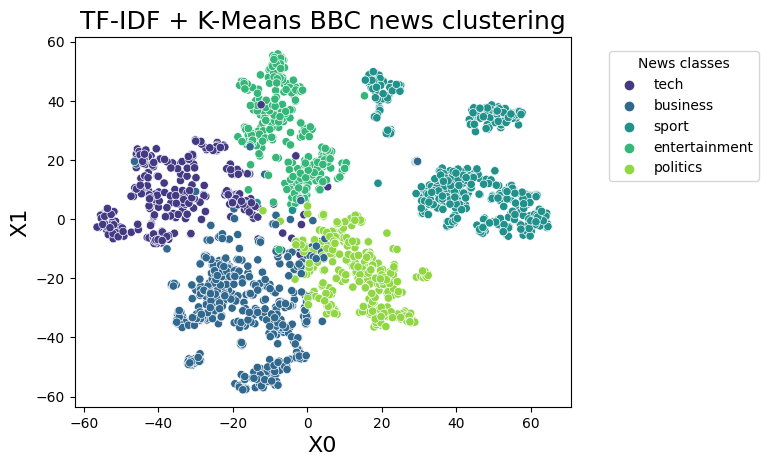

In [15]:
cluster_map_kmeans = {
    0: "politics",
    1: "sport",
    2: "tech",
    3: "business",
    4: "entertainment"
}
# apply mapping
df['cluster_mapped_kmeans'] = df['cluster_kmeans'].map(cluster_map_kmeans)

plt.title("TF-IDF + K-Means BBC news clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='cluster_mapped_kmeans',
                palette="viridis")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='News classes')
plt.show()

## Agglomerative clustering

Text(0.5, 1.0, 'Dataset dendrogram')

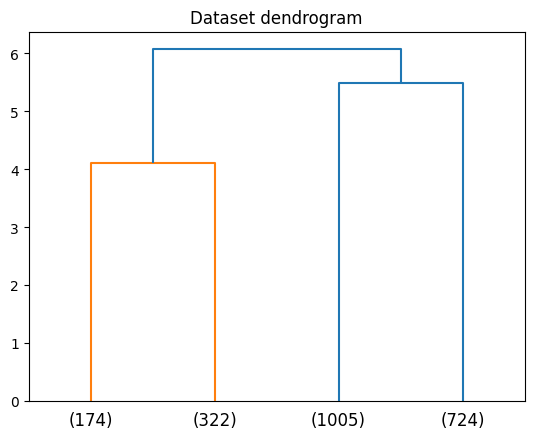

In [16]:
dendro = hierarchy.dendrogram(hierarchy.linkage(X.toarray(), method='ward'),
                              truncate_mode='level',
                              p=1)
plt.title('Dataset dendrogram')

In [17]:
#Find clusters with agglomerative algoritm from SKLEARN library
agg = AgglomerativeClustering(n_clusters=5,
                              affinity='euclidean',
                              linkage='ward')
agg.fit(X.toarray())
agg_clusters = agg.labels_

#add a column with clusters assigned by kmeans
df['cluster_agg'] = agg_clusters

In [18]:
get_top_keywords(X, agg_clusters, vectorizer, 10)


Cluster 0
players,season,first,team,england,match,cup,said,win,game

Cluster 1
firm,economy,market,growth,company,mr,year,us,bn,said

Cluster 2
net,computer,software,use,digital,mobile,said,technology,users,people

Cluster 3
films,said,year,actor,star,show,award,awards,best,film

Cluster 4
tory,minister,blair,would,said,government,party,election,mr,labour


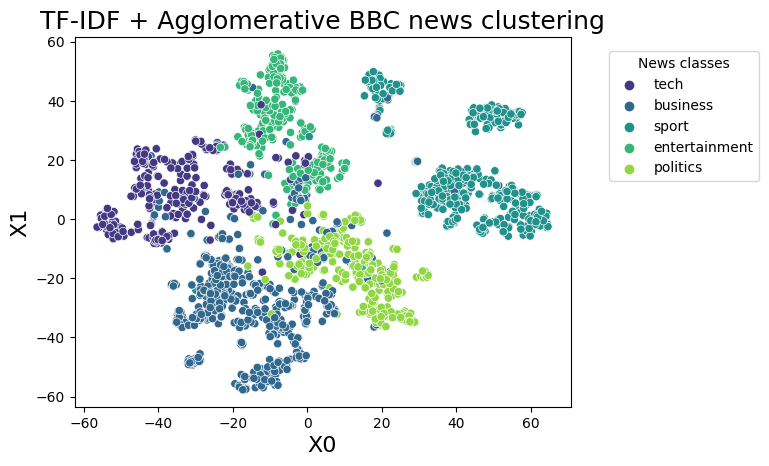

In [19]:
cluster_map_agg = {
    0: "sport",
    1: "business",
    2: "tech",
    3: "entertainment",
    4: "politics"
}
# apply mapping
df['cluster_mapped_agg'] = df['cluster_agg'].map(cluster_map_agg)

plt.title("TF-IDF + Agglomerative BBC news clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='cluster_mapped_agg',
                palette="viridis")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='News classes')
plt.show()

## Results analysis

**Comparison of results obtaied with different clustering methods**

In [20]:
labels_true = df['category']
labels = df['cluster_agg']

print('Estimated values for agglomerative clustering')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Davies-Bouldin index (full dimensionality): %0.3f" %
      metrics.davies_bouldin_score(X.toarray(), labels))
print("Davies-Bouldin index (T-SNE projection): %0.3f" %
      metrics.davies_bouldin_score(X_embedded, labels))

print("Silhouette Coefficient (full dimensionality): %0.3f" %
      metrics.silhouette_score(X.toarray(), labels))
print("Silhouette Coefficient (T-SNE projection): %0.3f" %
      metrics.silhouette_score(X_embedded, labels))
print("Rand-index: %0.3f" % metrics.rand_score(labels_true, labels))
print("Mutual-information: %0.3f" % metrics.mutual_info_score(labels_true, labels))

labels = df['cluster_kmeans']

print('\nEstimated values for KMeans clustering')

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Davies-Bouldin index: %0.3f" %
      metrics.davies_bouldin_score(X.toarray(), labels))
print("Silhouette Coefficient: %0.3f" %
      metrics.silhouette_score(X.toarray(), labels))
#sklearn.metrics.rand_score(labels_true, labels_pred)
print("Rand-index: %0.3f" % metrics.rand_score(labels_true, labels))
print("Mutual-information: %0.3f" % metrics.mutual_info_score(labels_true, labels))

Estimated values for agglomerative clustering
Homogeneity: 0.760
Completeness: 0.771
V-measure: 0.766
Davies-Bouldin index (full dimensionality): 8.162
Davies-Bouldin index (T-SNE projection): 1.012
Silhouette Coefficient (full dimensionality): 0.013
Silhouette Coefficient (T-SNE projection): 0.328
Rand-index: 0.924
Mutual-information: 1.218

Estimated values for KMeans clustering
Homogeneity: 0.867
Completeness: 0.872
V-measure: 0.870
Davies-Bouldin index: 7.736
Silhouette Coefficient: 0.014
Rand-index: 0.965
Mutual-information: 1.390


**Word Clouds for clusters found using K Means method**

In [21]:
!pip install wordcloud

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


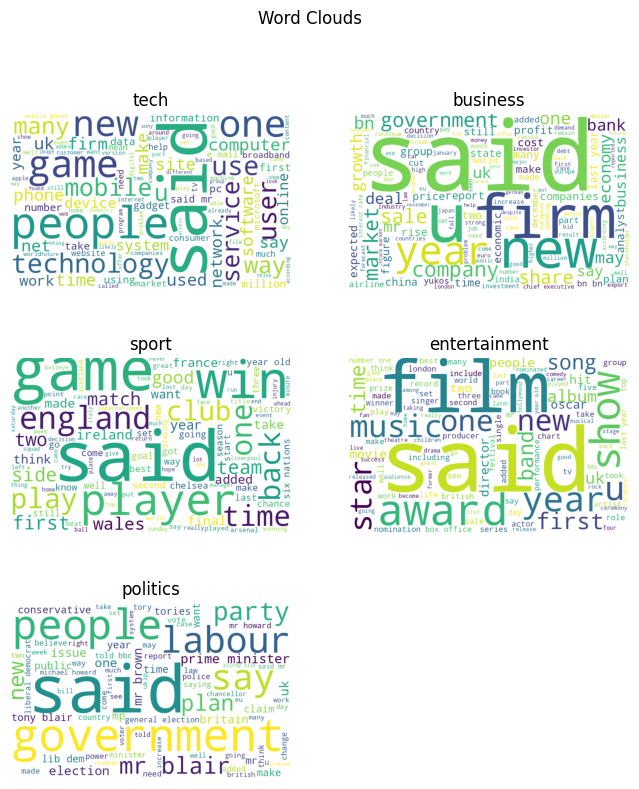

In [22]:
from wordcloud import WordCloud

fig = plt.figure(figsize=(8, 9))
fig.suptitle('Word Clouds')

k = 0
for idx in df['cluster_mapped_kmeans'].unique():

    plt.subplot(3, 2, k + 1)
    df_cluster = df[df['cluster_mapped_kmeans'] == idx]

    word_cloud = WordCloud(width=800,
                           height=500,
                           background_color='white',
                           min_font_size=14).generate(''.join(
                               df_cluster.cleaned.values.tolist()))
    plt.imshow(word_cloud)
    plt.title(str(idx))
    plt.axis('off')

    k += 1

plt.show()

## Misclassified points analysis

In [23]:
#Find the list of misclassified indexes 

diff_list_agg = np.where(df["category"]!=df['cluster_mapped_agg'])
diff_list_kmeans = np.where(df["category"]!=df['cluster_mapped_kmeans'])



misclassified_agg = df[df.index.isin(diff_list_agg[0])]
misclassified_kmeans = df[df.index.isin(diff_list_kmeans[0])]

In [24]:
print(len(diff_list_agg[0]))
print(len(diff_list_kmeans[0]))

220
100


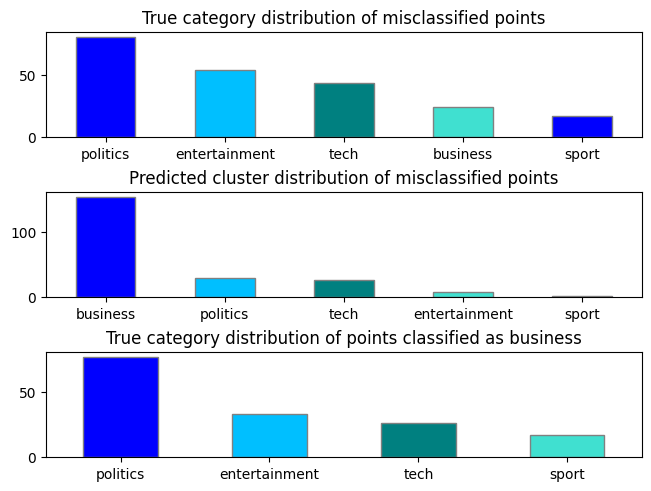

In [25]:
figs, ax = plt.subplots(3,layout="constrained")
plt.title('Agglomerative')

#Distribution of misclassified points - true category
misclassified_agg['category'].value_counts().plot(ax=ax[0],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'True category distribution of misclassified points' )


#Distribution of misclassified points - predicted cluster
misclassified_agg['cluster_mapped_agg'].value_counts().plot(ax=ax[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'Predicted cluster distribution of misclassified points' )

#Distribution (of true ) of misclassified as bussiness
misclassified_agg[misclassified_agg['cluster_mapped_agg']== 'business']['category'].value_counts().plot(ax=ax[2],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'True category distribution of points classified as business')

#plt.savefig('outlier_anal.png', dpi=300)
None

Distribution of misclassified points for K Means

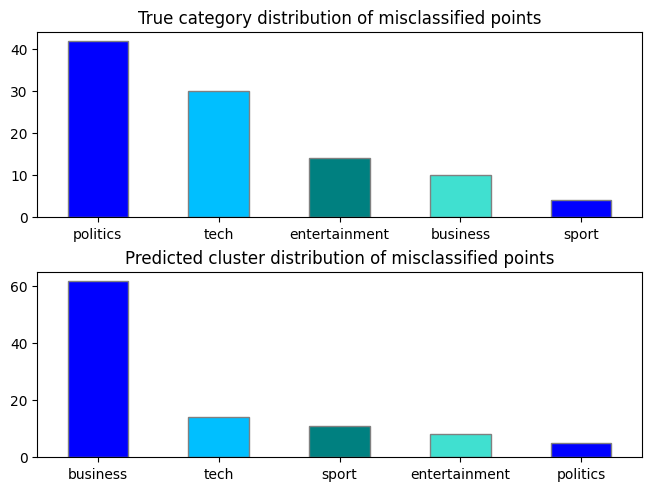

In [26]:
figs, ax = plt.subplots(2,layout="constrained")


#Distribution of misclassified points - true category
misclassified_kmeans['category'].value_counts().plot(ax=ax[0],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'True category distribution of misclassified points' )


#Distribution of misclassified points - predicted cluster
misclassified_kmeans['cluster_mapped_kmeans'].value_counts().plot(ax=ax[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'Predicted cluster distribution of misclassified points' )

#plt.savefig('outlier_anal.png', dpi=300)
None

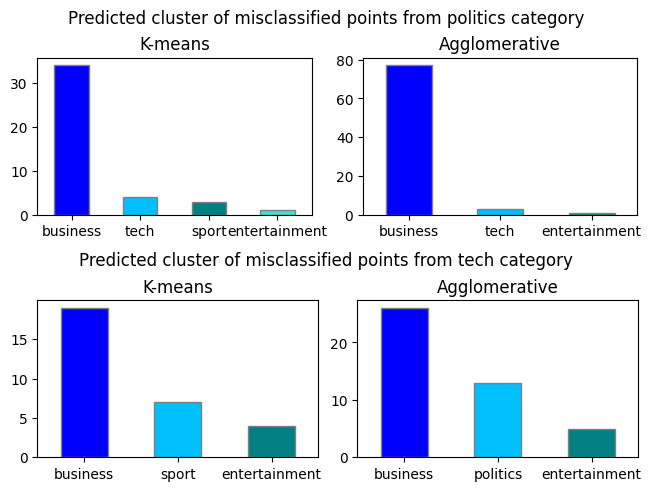

In [27]:
#Politics and tech plots

fig = plt.figure(constrained_layout=True)

subfigs = fig.subfigures(nrows=2, ncols=1)
subfigs[0].suptitle(f'Predicted cluster of misclassified points from politics category')
ax1 = subfigs[0].subplots(nrows=1, ncols=2)

#Distribution of misclassified points - true category
misclassified_kmeans[misclassified_kmeans['category']== 'politics']['cluster_mapped_kmeans'].value_counts().plot(ax=ax1[0],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'K-means' )


#Distribution (of true ) of misclassified as bussiness
misclassified_agg[misclassified_agg['category']== 'politics']['cluster_mapped_agg'].value_counts().plot(ax=ax1[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title =  'Agglomerative')


subfigs[1].suptitle(f'Predicted cluster of misclassified points from tech category')
ax2 = subfigs[1].subplots(nrows=1, ncols=2)


#Distribution of misclassified points - predicted cluster
misclassified_kmeans[misclassified_kmeans['category']== 'tech']['cluster_mapped_kmeans'].value_counts().plot(ax=ax2[0],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title = 'K-means'
                                   #title = 'Predicted cluster of misclassified points from tech category' 
                                   )

#plt.savefig('outlier_anal.png', dpi=300)

#Distribution of misclassified points - true category




misclassified_agg[misclassified_agg['category']== 'tech']['cluster_mapped_agg'].value_counts().plot(ax=ax2[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue","teal","turquoise"],
                                   edgecolor=["gray"],
                                   title =  'Agglomerative'
                                   #title =  'Predicted cluster of misclassified points from tech category'
                                   )

#plt.savefig('outlier_anal.png', dpi=300)
None


In [28]:
misclassified_kmeans['cluster_mapped_kmeans'].value_counts()['business']/misclassified_kmeans['cluster_mapped_kmeans'].value_counts().sum()
misclassified_agg['cluster_mapped_agg'].value_counts()['business']/misclassified_agg['cluster_mapped_agg'].value_counts().sum()

0.6954545454545454

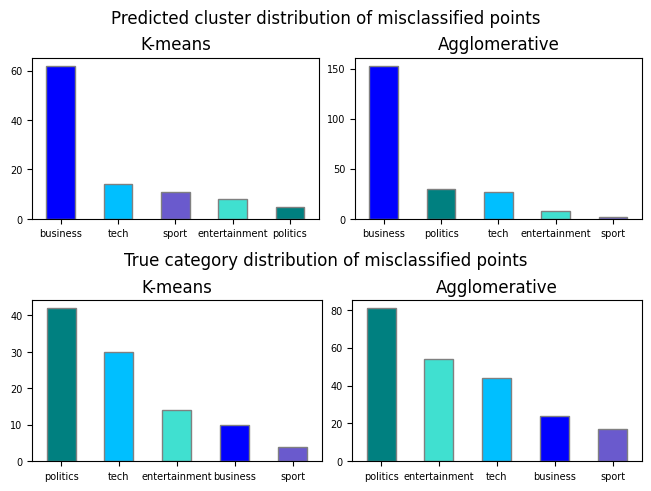

In [29]:
#Politics and tech plots



fig = plt.figure(constrained_layout=True)

plt.rc('xtick', labelsize=10) 

subfigs = fig.subfigures(nrows=2, ncols=1)
subfigs[0].suptitle(f'Predicted cluster distribution of misclassified points')
ax1 = subfigs[0].subplots(nrows=1, ncols=2)

#Distribution of misclassified points - true category
misclassified_kmeans['cluster_mapped_kmeans'].value_counts().plot.bar(ax=ax1[0],
                                   #kind='bar',
                                   rot=0,
                                   color=["blue","deepskyblue",'slateblue', "turquoise", "teal"],
                                   edgecolor=["gray"],
                                   title = 'K-means',
                                   fontsize = 7 )


#Distribution (of true ) of misclassified as bussiness
misclassified_agg['cluster_mapped_agg'].value_counts().plot(ax=ax1[1],
                                   kind='bar',
                                   rot=0,
                                   color=["blue","teal", "deepskyblue","turquoise", 'slateblue'],
                                   edgecolor=["gray"],
                                   title =  'Agglomerative',
                                   fontsize = 7)

subfigs[1].suptitle(f'True category distribution of misclassified points')
ax2 = subfigs[1].subplots(nrows=1, ncols=2)


#Distribution of misclassified points - predicted cluster
misclassified_kmeans['category'].value_counts().plot(ax=ax2[0],
                                   kind='bar',
                                   rot=0,
                                   color=["teal", "deepskyblue","turquoise","blue", 'slateblue'],
                                   edgecolor=["gray"],
                                   title = 'K-means',
                                   fontsize = 7
                                   )

#plt.savefig('outlier_anal.png', dpi=300)

#Distribution of misclassified points - true category




misclassified_agg['category'].value_counts().plot.bar(ax=ax2[1],
                                   #kind='bar',
                                   rot=0,
                                   color=[ "teal","turquoise","deepskyblue","blue", 'slateblue'],
                                   edgecolor=["gray"],
                                   title =  'Agglomerative',
                                   fontsize = 7
                                   )

plt.savefig('sublot_missclasified.png', dpi=300)
None


# Classification methods
## K-NN classifier

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(X.toarray(),
                                                    df["category"],
                                                    test_size=0.20,
                                                    random_state=911)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
classifier = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(f"Confusion matrix: \n{cm}")
print(f"Accuracy: \n{ac}")

Confusion matrix: 
[[97  0  6  0  5]
 [14 30 11  1 27]
 [12  1 65  0  5]
 [ 2  0  4 84  8]
 [ 4  0  6  0 63]]
Accuracy: 
0.7617977528089888


<AxesSubplot: >

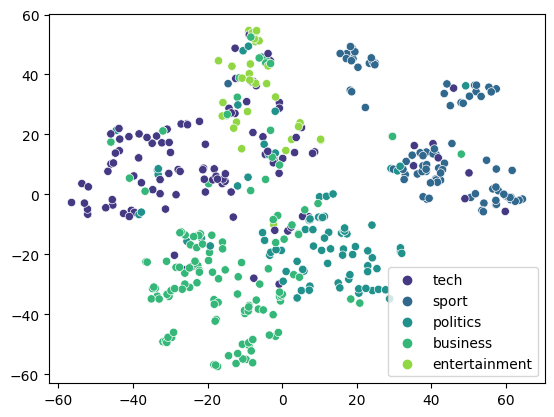

In [31]:
sns.scatterplot(x=X_embedded[y_test.index, 0], y=X_embedded[y_test.index,1], hue=y_pred, palette="viridis")

#sns.scatterplot(x=df1["x0"][y_test.index], y=df1["x1"][y_test.index], hue=y_pred, palette="viridis")
#something work with classes here

In [32]:
###########
#Test 1 of Supervised Classification: Dense NN
###########
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
import torch.optim as optim

cluster_map = {
    "politics": 0,
    "sport": 1,
    "tech": 2,
    "business": 3,
    "entertainment": 4
}
# apply mapping
df['category_nn'] = df['category'].map(cluster_map)

n = 300
pca = PCA(n_components=n, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())

X_train, X_test, y_train, y_test = train_test_split(pca_vecs,
                                                    df["category_nn"],
                                                    test_size=0.20,
                                                    random_state=911)

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
#Neural Network architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(300, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x


#Neural Network training loop

net = Net()
net = net.float()
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCHS = 15
loss = BCEWithLogitsLoss()
for epoch in range(EPOCHS):
    for X, y in zip(X_train, y_train):
        X_nn = torch.tensor(X)
        y_nn = nn.functional.one_hot(torch.tensor(y), num_classes=5).float()
        output = net(X_nn.float())
        loss_fun = loss(output, y_nn).mean()
        net.zero_grad()
        loss_fun.backward()
        optimizer.step()
    print(loss_fun)

tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0001, grad_fn=<MeanBackward0>)
tensor(2.5009e-05, grad_fn=<MeanBackward0>)
tensor(1.7213e-05, grad_fn=<MeanBackward0>)
tensor(5.9605e-07, grad_fn=<MeanBackward0>)
tensor(3.3379e-07, grad_fn=<MeanBackward0>)
tensor(9.5367e-08, grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for X, y in zip(X_test, y_test):
        X = torch.tensor(X)
        output = net(X.float())
        output = torch.sigmoid(output)
        if torch.argmax(output).item() == y:
            correct += 1
        total += 1

print("Accuracy: ", round(correct / total, 3))

Accuracy:  0.978


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=464588e9-04ee-4177-ac97-82ca4a34c5b0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>